In [2]:
import pandas as pd 
import numpy as np
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#data = pd.read_parquet("/home/adrian/workspace/Hierarchical-Clustering-Active-Learning-Text/tmp/data/complications_1000pos_and_neg_samples.parquet")
#data.head(2)
train = pd.read_parquet("/home/adrian/workspace/ActiveLearning/Active-Learning-for-Neural-Networks/data/diabetes/2000_random/2000random_1000train.parquet")
test = pd.read_parquet("/home/adrian/workspace/ActiveLearning/Active-Learning-for-Neural-Networks/data/diabetes/2000_random/2000random_1000test.parquet")
print(train.shape)
print(test.shape)
train.head(2)

(1000, 10)
(1000, 10)


,PMID,title,abstract,date,mesh_ui,mesh_mh,mesh_ui_diab,mesh_mh_diab,title_abstract_prep,vec
103,23424911,"""Local"" or ""mobile"" screening for diabetic ret...",Fundus photographs using non-mydriatic digital...,2012-12,"D000368,D019058,D003930,D003941,D005260,D00560...","Aged,Community Networks,Diabetic Retinopathy,D...",D003930,Diabetic Retinopathy,local or mobile screening for diabetic retinop...,"[-0.109889105, 0.2034432, 0.12958081, 0.131131..."
1638,8018225,Psychosocial aspects of type 1 diabetes mellit...,A total clinic sample of 67 diabetic and their...,1994,"D000223,D000293,D001290,D002648,D002652,D00267...","Adaptation, Psychological,Adolescent,Attitude,...",D003922,"Diabetes Mellitus, Type 1",psychosocial aspects of type 1 diabetes mellit...,"[-0.1481604, 0.1100086, 0.05811649, 0.15816991..."


In [2]:
y_test = test["mesh_ui_diab"].map(lambda mesh: 1 if mesh == "D048909" else 0).values
#y_train = train["mesh_ui_diab"].map(lambda mesh: 1 if mesh == "D048909" else 0)

#X_train = np.array(train["vec"].tolist())
X_test = np.array(test["vec"].tolist())

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=0)

print("Train: {}, Test: {}".format(train.shape, test.shape))

train["true_label"] = train["mesh_ui_diab"].map(lambda mesh: 1 if mesh == "D048909" else 0)
batchSize = 100
annotations = pd.DataFrame(columns=train.columns)
acc_list = []
prec_list = []
rec_list = []
f1_list = []
for i in range(5):
    print("\n==iteration i: {}".format(i))
    new_annot = train.sample(n=100)
    annotations = annotations.append(new_annot)
    
    #training = np.array(annotations["vec"].tolist())
    #labels = annotations["mesh_ui_diab"].map(lambda mesh: 1 if mesh == "D048909" else 0)
    

    pos = annotations[annotations["true_label"] == 1]
    neg = annotations[annotations["true_label"] == 0].sample(50)
    union = pos.append(neg).sample(frac=1.0)
    training = np.array(union["vec"].tolist())
    labels = pd.to_numeric(union["true_label"])
    
    #train["true_label"] = train["mesh_ui_diab"].map(lambda mesh: 1 if mesh == "D048909" else 0)
    #pos = train[train["true_label"] == 1].sample(20)
    #neg = train[train["true_label"] == 0].sample(20)
    #union = pos.append(neg)
    #training = np.array(union["vec"].tolist())
    #labels = union["true_label"]
    print("annotations: {}".format(annotations.shape))
    print("labels:")
    print(labels.value_counts())
    svm = SVC(kernel= 'linear', random_state=0)
    #svm = LinearSVC(random_state=0)
    #svm.fit(np.array(X_train[0:i].tolist()), y_train[0:i])
    svm.fit(training, labels)
 
    # Mode performance
    y_pred = svm.predict(np.array(X_test.tolist()))
    
    tp = 0
    fp = 0
    fn = 0
    tn = 0
    for j in range(len(y_pred)):
        if y_test[j] == y_pred[j] == 1: tp +=1
        if y_test[j] == 0 and y_pred[j] == 1: fp += 1
        if y_test[j] == 1 and y_pred[j] == 0: fn += 1
        if y_test[j] == 0 and y_pred[j] == 0: tn += 1
            
    acc = 1.0* (tp+tn) / (tp+tn+fp+fn) #accuracy_score(y_test, y_pred)
    if tp>0: prec = 1.0*tp / (tp+fp) 
    else: prec = 0.0#precision_score(y_test, y_pred)
    if tp>0: rec = 1.0*tp / (tp+fn) #recall_score(y_test, y_pred)
    else: rec = 0.0
    if prec > 0.0 and rec > 0.0: f1 = 2*prec*rec / (prec+rec) # f1_score(y_test, y_pred)
    else: f1 = 0.0
    acc_list.append(acc)
    prec_list.append(prec)
    rec_list.append(rec)
    f1_list.append(f1)
    print("tp: {}, fp: {}, fn: {}, tn: {}".format(tp, fp, fn, tn))
    print('Accuracy: {}, Precision: {}, Recall: {}, F1: {}'.format(acc, prec, rec, f1))

Train: (1000, 10), Test: (1000, 10)

==iteration i: 0
annotations: (100, 11)
labels:
0    50
1    11
Name: true_label, dtype: int64
tp: 0, fp: 0, fn: 95, tn: 905
Accuracy: 0.905, Precision: 0.0, Recall: 0.0, F1: 0.0

==iteration i: 1
annotations: (200, 11)
labels:
0    50
1    23
Name: true_label, dtype: int64
tp: 3, fp: 2, fn: 92, tn: 903
Accuracy: 0.906, Precision: 0.6, Recall: 0.031578947368421054, F1: 0.060000000000000005

==iteration i: 2
annotations: (300, 11)
labels:
0    50
1    33
Name: true_label, dtype: int64
tp: 45, fp: 67, fn: 50, tn: 838
Accuracy: 0.883, Precision: 0.4017857142857143, Recall: 0.47368421052631576, F1: 0.43478260869565216

==iteration i: 3
annotations: (400, 11)
labels:
0    50
1    44
Name: true_label, dtype: int64
tp: 55, fp: 122, fn: 40, tn: 783
Accuracy: 0.838, Precision: 0.3107344632768362, Recall: 0.5789473684210527, F1: 0.40441176470588236

==iteration i: 4
annotations: (500, 11)
labels:
1    51
0    50
Name: true_label, dtype: int64
tp: 69, fp: 237,

In [34]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.75, random_state=0)
print("Train: {}, Test: {}".format(X_train.shape, X_test.shape))


NameError: name 'data' is not defined

In [2]:
training = train[train]

svm = SVC(kernel= 'linear', random_state=0)
svm.fit(np.array(X_train[0:i].tolist()), y_train[0:i])

# Mode performance
y_pred = svm.predict(np.array(X_test.tolist()))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.749


In [4]:
# i = 50: acc: 0.634
# i = 100: acc: 0.737
# i = 150: acc: 0.721
# i = 200: acc: 0.749

,PMID,title,abstract,date,mesh_ui,mesh_mh,mesh_ui_diab,mesh_mh_diab,title_abstract_prep,vec,true_label
1284,25372483,Efficacy of standard and intensive statin trea...,AIMS\nTo estimate the efficacy of standard and...,2014,"D002318,D002561,D048909,D006801,D019161,D01601...","Cardiovascular Diseases,Cerebrovascular Disord...",D048909,Diabetes Complications,efficacy of standard and intensive statin trea...,"[-0.14197996, 0.13804576, 0.040885188, 0.21439...",1
1004,22520623,Diabetes and depressive symptoms among Korean ...,PURPOSE\nIn recognition of the impact of chron...,2012-09,"D000368,D000369,D001213,D001294,D003469,D00386...","Aged,Aged, 80 and over,Asian Americans,Attitud...",D048909,Diabetes Complications,diabetes and depressive symptoms among korean ...,"[-0.09494508, 0.17526884, 0.15795921, 0.207997...",1


## PLOT MEMORY CONSUMPTION

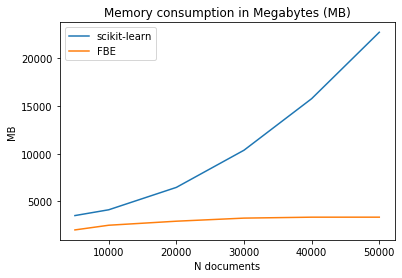

In [6]:
import matplotlib.pyplot as plt
x = [5000, 10000, 20000, 30000, 40000, 50000]
scikit = [3509, 4117, 6466, 10366, 15772, 22741]
FBE = [2004, 2495, 2918, 3242, 3340, 3341]

plt.plot(x, scikit, label="scikit-learn")
plt.plot(x, FBE, label="FBE")
plt.xlabel("N documents")
plt.ylabel("MB")
plt.title("Memory consumption in Megabytes (MB)")
plt.legend()
plt.savefig("/home/adrian/workspace/Hierarchical-Clustering-Active-Learning-Text/memoryConsumption_FBE_sklearn.png")
plt.show()

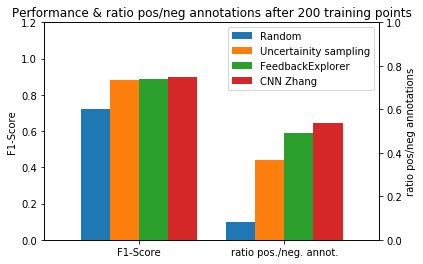

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

labels = ["F1-Score", "ratio pos./neg. annot."]
FBE_random = [0.72, 18.0/182]
FBE_uncertainitySampling = [0.88, 61.0/139]
FBE_best = [0.89, 74.0/126]
TF = [0.9, 0.645]

F1_scores = [0.72, 0.88, 0.89, 0.9]
ratios = [18.0/182, 61.0/139, 74.0/126, 0.645]

data = pd.DataFrame([F1_scores, ratios]
                    , columns= ["Random", "Uncertainity sampling", "FeedbackExplorer", "CNN Zhang"]
                   , index = labels)
#x = np.arange(len(labels))
#width = 0.5

#fig, ax = plt.subplots()
#rect_random = ax.bar(x - width/2, FBE_random, width/2, label="FBE random")
#rect_uncertainity = ax.bar(x - width/4, FBE_uncertainitySamplingSampling, width/2, label="FBE uncertainity sampling")
#rect_best = ax.bar(x + width/4, FBE_best, width/2, label="FBE best")
#rect_tf = ax.bar(x + width/2, TF, width/2, label="CNN tensorflow")

#ax.set_
title = "Performance & ratio pos/neg annotations after 200 training points"
#data.head()
ax = data.plot.bar(secondary_y=["ratio pos./neg. annotations"], title=title, width=0.8)
ax2 = ax.twinx()
#ax1.plot(x, y1, 'g-')
#ax2.plot(x, y2, 'b-')

#ax1.set_xlabel('X data')
ax.set_ylabel('F1-Score')
ax2.set_ylabel('ratio pos/neg annotations')
for tick in ax.get_xticklabels():
    tick.set_rotation(0)
ax.set_ylim(0.0, 1.2)
plt.savefig("performance&ratio_pos_neg_annotations_after_200_training_points.png")
#dir(ax)

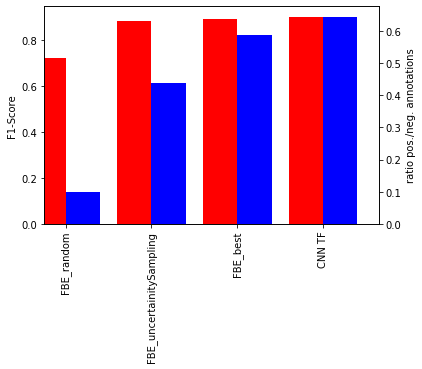

In [16]:
data = pd.DataFrame([FBE_random, FBE_uncertainitySampling, FBE_best, TF]
                    , columns= labels
                   , index = ["FBE_random", "FBE_uncertainitySampling", "FBE_best", "CNN TF"])

fig = plt.figure()
ax = fig.add_subplot(111)
ax2 = ax.twinx()

width = 0.4
data["F1-Score"].plot(kind="bar", color="red", ax=ax, width=width, position=1)
data["ratio pos./neg. annotations"].plot(kind="bar", color="blue", ax=ax2, width=width, position=0)
ax.set_ylabel("F1-Score")
ax2.set_ylabel("ratio pos./neg. annotations")
plt.show()

In [17]:
data.head()

,F1-Score,ratio pos./neg. annotations
FBE_random,0.72,0.098901
FBE_uncertainitySampling,0.88,0.438849
FBE_best,0.89,0.587302
CNN TF,0.90,0.645000
